# Development Manuscript Analysis: multivariate modeling
This notebook does the multivariate for all three endpoints using a variety of veature sets, including those chosen in the greedy forward selection notebook.

In [1]:
# Package imports...
# Basic:
import os
import sys
import psutil
# Data handling:
import io
import json
import pandas as pd
# Computations:
from datetime import datetime
from time import sleep
import numpy as np
from collections import Counter
# import ray
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
# Mine:
from modeling import npx_dc_correction, create_model, train_model, \
                     get_feature_importance_from_permutations, \
                     get_roc, aggregate_rocs
# Visualization:
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Object persistance:
import joblib
# Constants...
fig_font   = { "weight": "bold", "size": 12 }
title_font = { "weight": "bold", "size": 16 }
small_font = { "weight": "bold", "size": 8 }
matplotlib.rc( "font", **fig_font )

## Read in the F4, F5, and ACP data.
We're not reading from Domo because this paper is about the relative quantitation data taken in mid 2019 and analyzed in late 2019 through 2020. As such, we are reading archival versions of the protein concentration values that were uplaoded to Athena. Those are currently stored on [google drive](https://drive.google.com/drive/folders/1dYgunVtA0w50oRdW2MS0PDZI18NW5Ba7?usp=sharing).

In [2]:
# Specify the file names for the data tables.
excel_file_names = { "f4": "F4_Intensity_LOD_QC_ExtraOncologyIII-Olink+RBM_Shifts_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx", \
                     "f5": "F5_EPIC_Intensity_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_3TF.xlsx", \
                    "acp": "ACP_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx" }
# Read in the protein tables.
print( "Reading protien data..." )
read_start = datetime.now()
protein_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "prot", index_col = "sample.barcode" ) \
                   for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )
# Same for the clinical tables.
print( "Reading clinical data..." )
read_start = datetime.now()
clinical_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "clin_analysis", index_col = "sample.barcode" ) \
                    for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )

Reading protien data...
	...Finished in 0:00:03.763762
Reading clinical data...
	...Finished in 0:00:00.191650


## Extract the LIMS IDs/sample barcodes that correspond to real samples
The logic for this is _a little_ different for different studies, so we're going to handle them separately.

In [3]:
valid_lims_ids = { "f4": sorted( clinical_tables[ "f4" ][ clinical_tables[ "f4" ][ "Patient_Group" ].str.contains( "AIM3" ) ].index ), 
                   "f5": sorted( clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "F5_EPIC" ].index ), \
                  "acp": sorted( clinical_tables[ "acp" ][ ~clinical_tables[ "acp" ][ "Patient_Group" ].str.contains( "_PC" ) ].index ) }

## Bridge normalize the protein data from F5 to match the F4 Redo samples

In [4]:
# Define the list of biomarkers on the CAP...
biomarker_columns = [ "APLP1-Olink METABOLISM",    "CCL20-Olink INFLAMMATION",    "CD6-Olink INFLAMMATION",            "CDCP1-Olink INFLAMMATION",          "COL4A1-Olink CELL REGULATION", \
                      "CNTN2-Olink ORGAN DAMAGE",  "CXCL13-Olink ONCOLOGY II",    "CXCL9-Olink INFLAMMATION",          "FLRT2-Olink NEUROLOGY",             "GH-Olink CARDIOVASCULAR II", \
                      "IL-12B-Olink INFLAMMATION", "MOG-Olink CELL REGULATION",   "NEFL-Olink NEURO EXPLORATORY",      "OPG-Olink INFLAMMATION",            "OPN-Olink CARDIOVASCULAR III", \
                      "PRTG-Olink NEUROLOGY",      "SERPINA9-Olink ORGAN DAMAGE", "TNFRSF10A-Olink CARDIOVASCULAR II", "TNFSF13B-Olink CARDIOVASCULAR III", "VCAN-Olink METABOLISM" ]
# Identify the protein column names in the combined table.
protein_columns = [ bmkr.split( "-Olink" )[ 0 ].lower() for bmkr in biomarker_columns ]
# Isolate thee sample IDs for the redo samples in F5.
bridge_sample_ids = clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "AIM3_F4_redo" ].index
# Perform a linear regression to find the mapping of NPX values from F5 into the scale for F4 for each protein.
bridge_normalization_regr = { prot: linregress( protein_tables[ "f4" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values, \
                                                protein_tables[ "f5" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values ) \
                              for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Now create the adjusted NPX values for F5.
bridge_normalized_npx = { prot: ( protein_tables[ "f5" ].loc[ valid_lims_ids[ "f5" ] ][ bmkr ] * bridge_normalization_regr[ prot ].slope ) + bridge_normalization_regr[ prot ].intercept \
                          for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Finally, update the salient values in the F5 study.
for prot, bmkr in zip( protein_columns, biomarker_columns ):
    for lims_id in valid_lims_ids[ "f5" ]:
        protein_tables[ "f5" ].at[ lims_id, bmkr ] = bridge_normalized_npx[ prot ].loc[ lims_id ]

## Pull the clinical columns we're going to need.

In [5]:
 # Now, add the sample ID and protein columns to the combined table, and use the sample ID as the index value.
combined_tables = { study: pd.DataFrame( { bmkr.split( "-Olink" )[ 0 ].lower(): protein_tables[ study ].loc[ valid_lims_ids[ study ] ][ bmkr ].values.astype( np.float64 ) \
                                           for bmkr in biomarker_columns }, \
                                         index = valid_lims_ids[ study ] ) \
                    for study, lims_ids in valid_lims_ids.items() } 
# Set the clinical columns we are keeping for each study.
clinical_columns = { "f4": [ "Brain_Lesions", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis", "ARR" ], \
                     "f5": [ "Brain_Lesions", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis" ], \
                    "acp": [ "Label", "Age", "Sex", "DiseaseDuration" ] }
# Now iterate through the studies and the clinical tables associated with each, and add them into the combined table.
# Iterate over the studies...
for study, lims_ids in valid_lims_ids.items():
    # ...and over the clinical columns...
    for clin_col in clinical_columns[ study ]:
        combined_tables[ study ][ clin_col.lower().replace( "sedu", "se_du" ).replace( "odmi", "od_mi" ).replace( "usdi", "us_di") ] = \
                clinical_tables[ study ].loc[ lims_ids ][ clin_col ].values.astype( np.float64 )

## Demographic/clinical corrections.

In [6]:
# Now get ready to run this function. Split out the protein columns...
combined_protein_data = { study: combined_tables[ study ][ protein_columns ] \
                          for study in combined_tables.keys() }
# ...and the clinical ones.
combined_clinical_data = { study: combined_tables[ study ][ [ "age", "sex", "disease_duration" ] ]
                           for study in combined_tables.keys() }
# ...add an endpoint column as the brain lesion count clipped at 0 and 1 (to make it the binarized general disease activity) to the combined clinical table for F4 and F5.
for study in [ "f4", "f5" ]:
    combined_clinical_data[ study ] = combined_clinical_data[ study ].assign( endpoint = combined_tables[ study ][ "brain_lesions" ].clip( 0., 1. ).values )
# ...and add in the clinical endpoint for ACP:
combined_clinical_data[ "acp" ] = combined_clinical_data[ "acp" ].assign( endpoint = combined_tables[ "acp" ][ "label" ] )
# Run the function.
dc_corrected_protein_data, dc_correction_models = {}, {}
for study in combined_clinical_data.keys():
    dc_corrected_protein_data[ study ], dc_correction_models[ study ] = npx_dc_correction( combined_protein_data[ study ], \
                                                                                          combined_clinical_data[ study ], \
                                                                                           holdout_non_npx_columns = [ "endpoint" ], \
                                                                                                    train_col_name = "endpoint", \
                                                                                                     log_transform = False, \
                                                                                                 train_on_neg_samp = True, \
                                                                                                       outlier_pct = 5., \
                                                                                                           verbose = False )


## Construct feature matricies and label vectors for all three endpoints.
* Gd lesions (Gd) uses F4 and F5
* Clinical relapse status (CRS) uses ACP
* Annualized relapse rate (ARR) uses F4

For Gd lesion classification, we're going to explicitly define three disease activity endpoints:
1. "General Disease Activity" (GDA): no lesions versus any number of them
2. "Subtle Disease Activity" (SDA): no lesions versus one lesion (all other numbers are set to `NaN`)
2. "Extreme Disease Activity" (EDA): no lesions versus three or more lesions (all other numbers are set to `NaN`)

In keeping with previous versions of this analysis, Gd lesion regression will be clipped at five lesions to avoid any nonlinear/saturation effects.

In [7]:
# Initialize dictionaries to hold the pandas data frame for the features and the series for the labels.
feature_data, labels = {}, {}
# Construct the feature data frame for Gd lesions. It's a concatenation of F4 and F5.
feature_data[ "gd" ] = pd.concat( [ dc_corrected_protein_data[ "f4" ][ combined_tables[ "f4" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ], \
                                    dc_corrected_protein_data[ "f5" ][ combined_tables[ "f5" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ] ], \
                                  axis = 0, ignore_index = False )
# ...and now the label series.
labels[ "gd" ] = pd.concat( [ combined_tables[ "f4" ][ combined_tables[ "f4" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ], \
                              combined_tables[ "f5" ][ combined_tables[ "f5" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ] ], \
                            axis = 0, ignore_index = False )[ "brain_lesions" ]
# Now construct the classification endpoints (GDA, SDA, and EDA).
labels[ "gda" ] = labels[ "gd" ].clip( 0., 1. )
labels[ "sda" ] = pd.Series( [ 0. if gdlc == 0. else 1. if gdlc == 1. else np.nan \
                               for gdlc in labels[ "gd" ].values ], \
                             index = labels[ "gd" ].index )
labels[ "eda" ] = pd.Series( [ 0. if gdlc == 0. else 1. if gdlc >= 3. else np.nan \
                               for gdlc in labels[ "gd" ].values ], \
                             index = labels[ "gd" ].index )
# Now make sure that the features and labels are _explicitly_ indexed in the same order--not sure if this is strictly necessary, 
# but I can imagine it removing some potential obsticles later.
feature_data[ "gd" ] = feature_data[ "gd" ].loc[ labels[ "gd" ].index ]
# Now, do clinical relapse status. It's _just_ ACP.
feature_data[ "crs" ] = dc_corrected_protein_data[ "acp" ]
labels[ "crs" ] = combined_tables[ "acp" ][ "label" ]
feature_data[ "crs" ] = feature_data[ "crs" ].loc[ labels[ "crs" ].index ]
# Finally, do annualized relapse rate. It's _just_ F4. 
feature_data[ "arr" ] = dc_corrected_protein_data[ "f4" ]
# Remember that we need to binarize ARR with threshold filters.
arr_lo, arr_hi = 0.2, 1.
labels[ "arr" ] = pd.Series( [ 0. if combined_tables[ "f4" ].loc[ ind ][ "arr" ] <  arr_lo else \
                               1. if combined_tables[ "f4" ].loc[ ind ][ "arr" ] >= arr_hi else \
                               np.nan \
                               for ind in dc_corrected_protein_data[ "f4" ].index ], \
                             index = dc_corrected_protein_data[ "f4" ].index )
# Down-select the ARR features to only those with non-nan labels.
arr_to_keep = labels[ "arr" ][ labels[ "arr" ].notna() ].index
feature_data[ "arr" ] = feature_data[ "arr" ].loc[ arr_to_keep ]
labels[       "arr" ] = labels[       "arr" ].loc[ arr_to_keep ]

## Construct train/test splits for each endpoint.
We're going to do an ensemble of bootstraps, where each one trains on 67% of the data and tests on 33%. I'll debug with a few dozen and finalize this business with 1,000 or so.

We're going to need to do a bit of stratification here to make sure that some of our endpoints with a bad class imbalance (EDA, ARR mostly) have enough of the minority class in each of the training and testing splits for each bootstrap.

In [8]:
# Set the number of bootstraps to do.
n_bootstraps = 1000
# Fraction of the data set on which we're going to train.
training_frac = 0.67
# Set the minimum class membership.
min_class_count = 3
# Initialize a dictionary to hold all the splits for each endpoint.
train_splits, test_splits = { endpoint: [] for endpoint in labels.keys() }, \
                            { endpoint: [] for endpoint in labels.keys() }
# Iterate over the endpoints.
for endpoint in labels.keys():
    # Calculate the size of the training splits
    train_size = int( labels[ endpoint ].size * training_frac )
    # Keep adding splits until we get enough!
    while ( ( len( train_splits[ endpoint ] ) < n_bootstraps ) & \
            ( len(  test_splits[ endpoint ] ) < n_bootstraps ) ):
        # Generate a proposed train split.
        this_train = np.random.choice( labels[ endpoint ].index, \
                                       size = train_size, \
                                    replace = False )
        # Dump the rest of the indecies into the proposed test split.
        this_test = np.array( [ ind for ind in labels[ endpoint ].index \
                                if ind not in this_train ] )
        # Make sure that the label series for each split isn't monolithic.
        if ( ( np.count_nonzero( labels[ endpoint ].loc[ this_train ] ) > min_class_count ) & \
             ( np.count_nonzero( labels[ endpoint ].loc[ this_test  ] ) > min_class_count ) ):
            # ...and if it is, add it to the list.
            train_splits[ endpoint ].append( this_train )
            test_splits[  endpoint ].append( this_test  )

## Define the feature sets
We're going to look at three feature sets for each endpoint/analysis: 
1. the optimal features from the GFS notebook,
2. NfL only, and 
3. all proteins except NfL.

In [9]:
features = { "nefl_only": sorted( [ "nefl" ] ), \
          "all_but_nefl": sorted( [ prot for prot in protein_columns if prot != "nefl" ] ), \
           "gfs_gd_regr": sorted( [ "nefl", "gh", "il-12b", "cntn2", "mog", "tnfsf13b" ] ), \
           "gfs_gd_clas": sorted( [ "nefl", "cntn2", "tnfrsf10a", "cxcl13", "tnfsf13b" ] ), \
          "gfs_crs_clas": sorted( [ "nefl", "serpina9", "tnfsf13b", "flrt2" ] ), \
          "gfs_arr_clas": sorted( [ "nefl", "opg", "cd6" ] ) }

In [10]:
len( test_splits[ "gd" ] )

1000

## Gd lesion regression
Recall that we will clip our regression analysis at five lesions to avoid most idiosyncrasies assocoated with nonlinear and saturation effects. We'll get started by hyperparameter tuning the regularization strength.

Hyperparameter Tuning for Gd lesion regression:   0%|          | 0/20000 [00:00<?, ?it/s]

Hyperparameter Tuning for Gd lesion regression: 100%|██████████| 20000/20000 [00:33<00:00, 591.80it/s]


Making predictions...
Scoring model performance...
...Done.


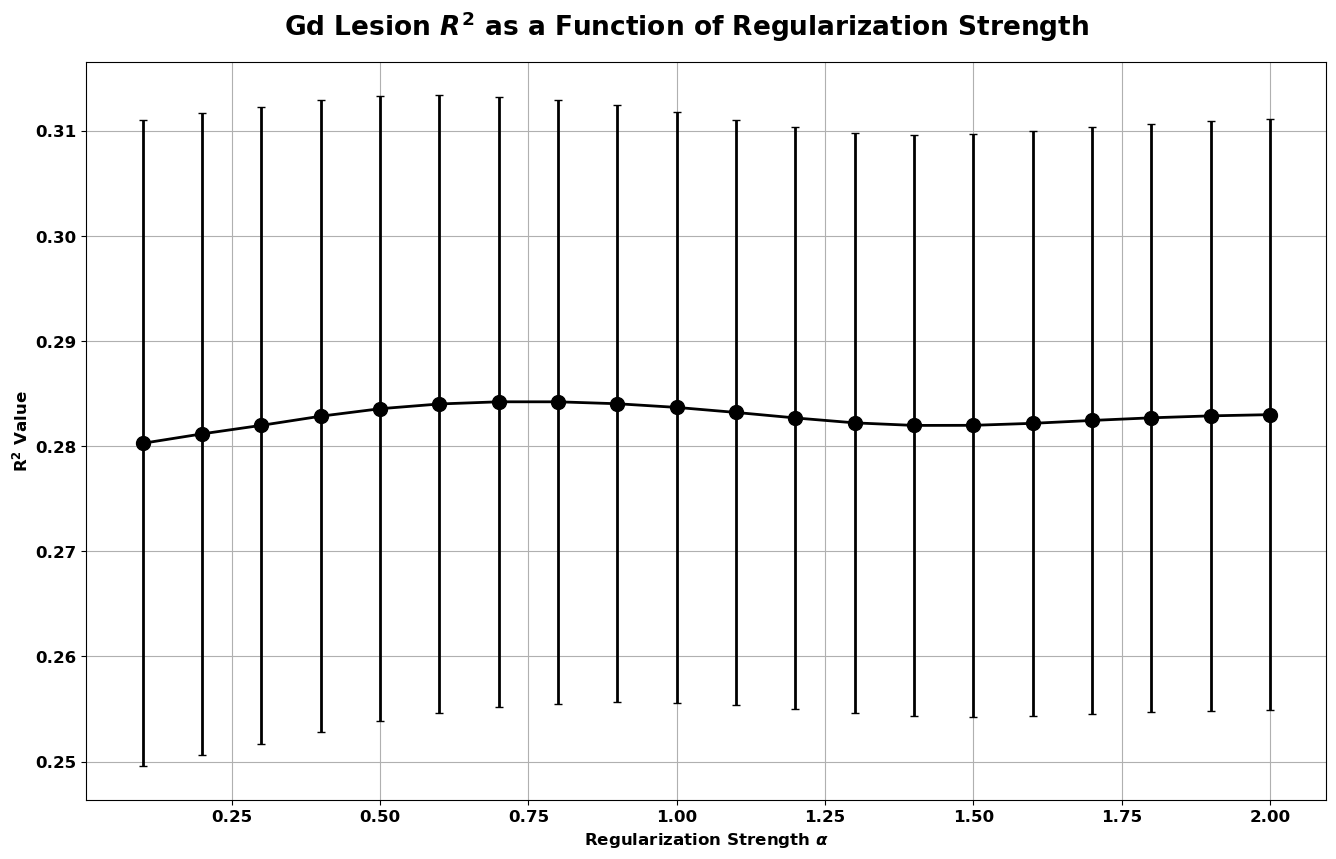

In [11]:
# Define the range of alphas over which we're going to scan.
alphas = np.arange( 0.1, 2.01, 0.1 )
gd_regr_model_configs = [ { "model_type": "Poisson", 
                                 "alpha": alpha, 
                                "solver": "lbfgs", 
                            "warm_start": True, 
                         "fit_intercept": True, 
                                   "tol": 1.e-4, 
                              "max_iter": 1000 } \
                          for alpha in alphas ]
# Specify the upper clip limit for Gd lesions.
gd_clip_lim = 5
with tqdm( total = n_bootstraps * len( gd_regr_model_configs ), \
            desc = "Hyperparameter Tuning for Gd lesion regression" ) \
        as pbar:
    gd_regr_hp_tune_models = [ [ train_model( create_model( model_type = gd_regr_model_config[ "model_type" ], config = gd_regr_model_config ), \
                                              feature_data[ "gd" ].loc[ tr_spl ][ features[ "gfs_gd_regr" ] ].values.astype( np.float64 ), \
                                                    labels[ "gd" ].loc[ tr_spl ].clip( 0., gd_clip_lim ).values.astype( np.float64 ), \
                                              scaling = False, progress = pbar )  \
                                 for tr_spl in train_splits[ "gd" ] ] \
                               for gd_regr_model_config in gd_regr_model_configs ]
# ...isolate the non-nan rows in the data and the labels across the test splits.
non_nan_rows = ( ( ~feature_data[ "gd" ][ features[ "gfs_gd_regr" ] ].isna().any( axis = 1 ) ) & ( ~labels[ "gd" ].isna() ) )
non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
# Generate predictions for this model/test split.
print( "Making predictions..." )
gd_regr_hp_tune_predictions = [ [ pd.Series( model.predict( feature_data[ "gd" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ features[ "gfs_gd_regr" ] ].values.astype( np.float64 ) ), \
                                             index = list( set( te_spl ).intersection( non_nan_rows ) ) ) \
                                  for model, te_spl in zip( hp_models, test_splits[ "gd" ] ) ]
                                for hp_models in gd_regr_hp_tune_models ]
# Evaluate the predictions we just made..
print( "Scoring model performance..." )
gd_regr_hp_tune_r2_vals = [ [ linregress( predictions.clip( 0., gd_clip_lim ).values, \
                                          labels[ "gd" ].loc[ predictions.index ].clip( 0., gd_clip_lim ).values ).rvalue ** 2. \
                              for predictions in hp_preds ] \
                            for hp_preds in gd_regr_hp_tune_predictions ]
print( "...Done." )
# Plot the model performance (R^2) as a function of regularization strength.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
sub_plot.errorbar( alphas, [ np.mean( r2_vals ) for r2_vals in gd_regr_hp_tune_r2_vals ],
                   yerr = [ 0.5 * np.std( r2_vals, ddof = 1 ) for r2_vals in gd_regr_hp_tune_r2_vals ],
                   fmt = "-o", color = "black", markersize = 10., linewidth = 2., capsize = 3. )
fig.suptitle( "Gd Lesion $R^2$ as a Function of Regularization Strength", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
sub_plot.set_xlabel( "Regularization Strength $\\alpha$", fontdict = fig_font )
sub_plot.set_ylabel( "R$^{2}$ Value", fontdict = fig_font )

sub_plot.grid( True )

Not a dranatic difference across our scan... Let's just stick with alpha = 1...

In [12]:
# Pick the best regression configuration.
gd_regr_model_config = { "model_type": "Poisson", 
                              "alpha": 1., 
                             "solver": "lbfgs", 
                         "warm_start": True, 
                      "fit_intercept": True, 
                                "tol": 1.e-4, 
                           "max_iter": 1000 }
# Initialize arrays to hold the: models, predictions, and R^2 values for each bootstrap.
gd_regr_models, gd_regr_predictions, gd_regr_r2_vals = { feat_set: [] for feat_set in [ "gfs_gd_regr", "nefl_only", "all_but_nefl" ] }, \
                                                       { feat_set: [] for feat_set in [ "gfs_gd_regr", "nefl_only", "all_but_nefl" ] }, \
                                                       { feat_set: [] for feat_set in [ "gfs_gd_regr", "nefl_only", "all_but_nefl" ] }
# Iterate over the feature sets for this analysis.
for feat_set in gd_regr_models.keys():
    print( "{:} Features...".format( feat_set) )
    # Set up a progress bar to track our progress.
    with tqdm( total = n_bootstraps, \
                desc = "Training Gd lesion count regr. models" ) \
        as pbar:
        # Create and train the models.
        gd_regr_models[ feat_set ] = [ train_model( create_model( model_type = gd_regr_model_config[ "model_type" ], config = gd_regr_model_config ), \
                                                    feature_data[ "gd" ].loc[ tr_spl ][ features[ feat_set ] ].values.astype( np.float64 ), \
                                                          labels[ "gd" ].loc[ tr_spl ].clip( 0., gd_clip_lim ).values.astype( np.float64 ), \
                                                    scaling = False, progress = pbar )  \
                                       for tr_spl in train_splits[ "gd" ] ]
    # ...isolate the non-nan rows in the data and the labels across the test splits.
    non_nan_rows = ( ( ~feature_data[ "gd" ][ features[ feat_set ] ].isna().any( axis = 1 ) ) & ( ~labels[ "gd" ].isna() ) )
    non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
    # Make predictions for each model trained on one of our training splits.
    with tqdm( total = n_bootstraps, \
                desc = "Predicting Gd lesion count" ) \
        as pbar:
        for model, te_spl in zip( gd_regr_models[ feat_set ], test_splits[ "gd" ] ):
            # Generate predictions for this model/test split.
            gd_regr_predictions[ feat_set ].append( pd.Series( model.predict( feature_data[ "gd" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ features[ feat_set ] ].values.astype( np.float64 ) ), \
                                                                index = list( set( te_spl ).intersection( non_nan_rows ) ) ) )
            # Iterate the progress bar.
            pbar.update( 1 )
    # Evaluate the predictions we just made..
    with tqdm( total = n_bootstraps, \
                desc = "Evaluating Gd lesion predictions" ) \
        as pbar:
        for predictions in gd_regr_predictions[ feat_set ]:
            # Evaluate the predictions for this model/test split.
            gd_regr_r2_vals[ feat_set ].append( linregress( predictions.clip( 0., gd_clip_lim ).values, \
                                                            labels[ "gd" ].loc[ predictions.index ].clip( 0., gd_clip_lim ).values ).rvalue ** 2. )
            # Iterate the progress bar.
            pbar.update( 1 )

gfs_gd_regr Features...


Evaluating Gd lesion predictions: 100%|██████████| 1000/1000 [00:00<00:00, 1995.60it/s]


nefl_only Features...


Evaluating Gd lesion predictions: 100%|██████████| 1000/1000 [00:00<00:00, 2091.48it/s]


all_but_nefl Features...


Evaluating Gd lesion predictions: 100%|██████████| 1000/1000 [00:00<00:00, 2007.14it/s]


Extract the feature importance for the GFS features.

In [13]:
# Initialize a list to store the feature importance vectors
gd_regr_feat_imp = []
# Set the number of permutations to do.
n_permutations = 50
# Set up a progress bar to track our progress.
with tqdm( total = n_bootstraps, \
            desc = "Extract feature importance vectors" ) \
      as pbar:
      # Iterate over the models and the data used to train them.
      for model, tr_split in zip( gd_regr_models[ "gfs_gd_regr" ], train_splits[ "gd" ] ):
            # Extract the feature importance vector using permutations.
            gd_regr_feat_imp.append( get_feature_importance_from_permutations( model, \
                                                                               feature_data[ "gd" ].loc[ tr_split ][ features[ "gfs_gd_regr" ] ], \
                                                                                     labels[ "gd" ].loc[ tr_split ].clip( 0., gd_clip_lim ), \
                                                                               n_rounds = n_permutations, classification = False, metric = "r2", softmax = True ) )
            # Iterate the progress bar.
            pbar.update( 1 )
# Rebundle these into a nice happy numpy array.
gd_regr_feat_imp = np.concatenate( [ feat_imps.reshape( n_permutations, \
                                                        len( features[ "gfs_gd_regr" ] ), \
                                                        1 ) \
                                     for feat_imps in gd_regr_feat_imp ], \
                                   axis = 2 )

Extract feature importance vectors: 100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


In [14]:
print( "Number of samples with lesion count > {:}: {:} out of {:} ({:1.2f}%).".format( gd_clip_lim, 
                                                                                       np.count_nonzero( labels[ "gd" ].to_numpy() > 5. ), 
                                                                                       labels[ "gd" ].to_numpy().shape[ 0 ],
                                                                                       100. *  np.count_nonzero( labels[ "gd" ].to_numpy() > 5. ) / \
                                                                                               labels[ "gd" ].to_numpy().shape[ 0 ] ) )
gd_les_counter = Counter( labels[ "gd" ].to_numpy() )
pd.DataFrame( { "Gd Les. Count": sorted( gd_les_counter.keys() ),
           "Number of Patients": [ gd_les_counter[ gd_les_count ] \
                                   for gd_les_count in sorted( gd_les_counter.keys() ) ] } ).set_index( "Gd Les. Count", drop = True )

Number of samples with lesion count > 5: 28 out of 501 (5.59%).


,Number of Patients
Gd Les. Count,
0.0,138
1.0,126
2.0,148
3.0,39
4.0,15
5.0,7
6.0,12
7.0,1
8.0,3


Let's make a quick plot of the performance of the models we just trained.

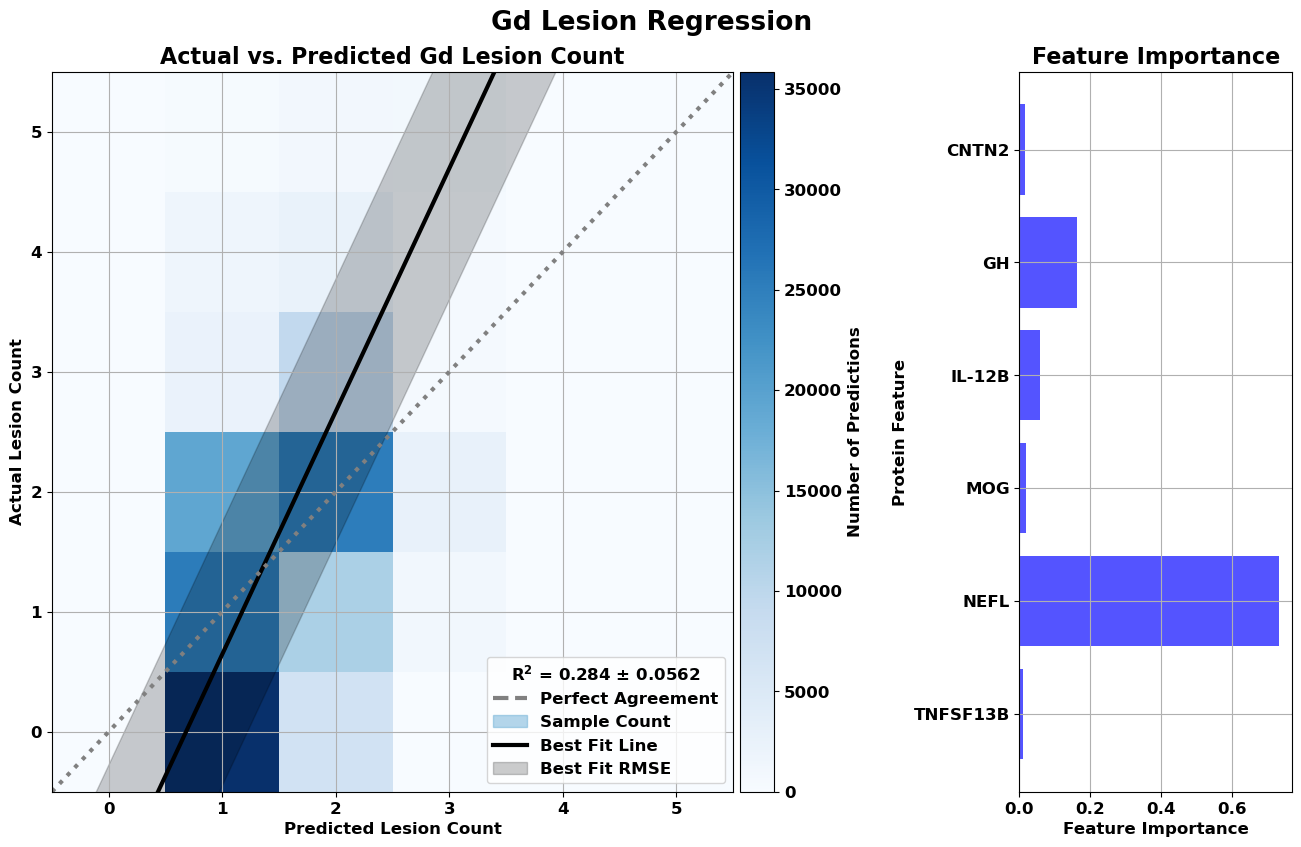

In [15]:
# Some constants.
lesion_count_bins = np.arange( -0.5, min( [ labels[ "gd" ].clip( 0., gd_clip_lim ).values.astype( np.float64 ).max(), gd_clip_lim ] ) + 0.6, 1. )
# Create the figure.
fig, sub_plot = plt.subplots( 1, 2, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white", \
                              gridspec_kw = { "width_ratios": [ 2.5, 1. ] } )
# Draw a 2D histogram of labels vs. predictions on each subplot.
lesion_count_histo = sub_plot[ 0 ].hist2d( np.concatenate( [ predictions.values.astype( np.float64 ) \
                                                             for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                           np.concatenate( [ labels[ "gd" ].loc[ predictions.index ].values.astype( np.float64 ) \
                                                             for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                           [ lesion_count_bins, lesion_count_bins ], cmap = "Blues", alpha = 1. )
# Do a linear regression of all the predictions vs. all the labels.
gd_regr_lin_regr = linregress( np.concatenate( [ predictions.values.astype( np.float64 ) \
                                                 for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                               np.concatenate( [ labels[ "gd" ].loc[ predictions.index ].values.astype( np.float64 ) \
                                                 for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ) )
gd_regr_rmse = mean_squared_error( np.concatenate( [ predictions.values.astype( np.float64 ) \
                                                     for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                   np.concatenate( [ labels[ "gd" ].loc[ predictions.index ].values.astype( np.float64 ) \
                                                     for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                   squared = False )
# Plot the best fit line along with the standard error.
best_fit_lines = sub_plot[ 0 ].plot( lesion_count_bins, \
                                     ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept, \
                                     "-", color = "black", linewidth = 3. )
best_fit_error = sub_plot[ 0 ].fill_between( lesion_count_bins, \
                                             ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept - ( 0.5 * gd_regr_rmse ), \
                                             ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept + ( 0.5 * gd_regr_rmse ), \
                                             color = "black", alpha = 0.2 )
# Show the y = x line for perfect agreement.
perfect_agreement = sub_plot[ 0 ].plot( lesion_count_bins, lesion_count_bins, ":", color = "gray", linewidth = 3. )
# Plot the feature importance vector averaged over the bootstraps.
sub_plot[ 1 ].barh( np.arange( len( features[ "gfs_gd_regr" ] ) ), \
                    ( gd_regr_feat_imp.mean( axis = ( 0, 2 ) ) / gd_regr_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    xerr = ( ( ( gd_regr_feat_imp.std( axis = 2 ) / \
                                 np.sqrt( n_permutations ) ).std( axis = 0 ) / \
                                 np.sqrt( n_bootstraps ) ) / \
                               gd_regr_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    height = 0.8, align = "center", color = "blue", alpha = 0.67 )
# Formatting.
color_bar = fig.colorbar( lesion_count_histo[ -1 ], \
                          cax = sub_plot[ 0 ].inset_axes( bounds = [ 1.01, 0., 0.05, 1. ] ) )
fig.suptitle( "Gd Lesion Regression", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.6, hspace = 0.05, top = 0.91 )
sub_plot[ 0 ].set_title( "Actual vs. Predicted Gd Lesion Count", fontdict = title_font )
sub_plot[ 0 ].set_xlabel( "Predicted Lesion Count", fontdict = fig_font )
sub_plot[ 0 ].set_ylabel( "Actual Lesion Count", fontdict = fig_font )
sub_plot[ 0 ].set_xlim( [ lesion_count_bins.min(), lesion_count_bins.max() ] )
sub_plot[ 0 ].set_ylim( [ lesion_count_bins.min(), lesion_count_bins.max() ] )
color_bar.set_label( "Number of Predictions", fontdict = fig_font )
sub_plot[ 0 ].legend( [ matplotlib.lines.Line2D( [ 0 ],[ 0 ], color = "gray", linewidth = 3., linestyle = "--" ), \
                        mpatches.Patch( color = matplotlib.cm.Blues( 0.5 ), alpha = 0.5 ), \
                        matplotlib.lines.Line2D( [ 0 ],[ 0 ], color = "black", linewidth = 3. ), \
                        mpatches.Patch( color = "black", alpha = 0.2 ) ], \
                      [ "Perfect Agreement", "Sample Count", "Best Fit Line", "Best Fit RMSE" ], \
                      title = "R$^2$ = {:1.3} $\pm$ {:1.3}".format( np.mean( gd_regr_r2_vals[ "gfs_gd_regr" ] ), \
                                                                    np.std(  gd_regr_r2_vals[ "gfs_gd_regr" ] ) ), \
                      loc = "lower right" )
sub_plot[ 1 ].set_title( "Feature Importance", fontdict = title_font )
sub_plot[ 1 ].set_xlabel( "Feature Importance", fontdict = fig_font )
sub_plot[ 1 ].set_ylabel( "Protein Feature", fontdict = fig_font )
sub_plot[ 1 ].set_yticks( np.arange( len( features[ "gfs_gd_regr" ] ) ) )
sub_plot[ 1 ].set_yticklabels( [ feat.upper() for feat in features[ "gfs_gd_regr" ][ ::-1 ] ], \
                               fontdict = fig_font )
for sp in sub_plot:
    sp.grid( True )

OK, let's hold onto this for later in the notebook. In the mean time, let's move on to the other endpoints/analyses.

## Gd lesion detection
We're going to train models for each training split on GDA, and then evaluate their performance on GDA, SDA, and EDA.

In [16]:
# Specify the configuration for this model.
gd_clas_model_config = { "model_type": "LogRegr", \
                               "dual": False, \
                      "fit_intercept": True, \
                           "max_iter": 1000000, \
                             "n_jobs": -1, \
                       "class_weight": "balanced", \
                             "solver": "saga", \
                            "penalty": "elasticnet", \
                                  "C": 0.1, \
                                "tol": 0.01, \
                           "l1_ratio": 0.1 }
# Initialize arrays to hold the: models, predictions, and AUROC values for each bootstrap.
gd_clas_models, gd_clas_predictions, gd_clas_auroc_vals = { feat_set: [] for feat_set in [ "gfs_gd_clas", "nefl_only", "all_but_nefl" ] }, \
                                                          { feat_set: { da: [] for da in [ "gda", "sda", "eda" ] } \
                                                            for feat_set in [ "gfs_gd_clas", "nefl_only", "all_but_nefl" ] }, \
                                                          { feat_set: { da: [] for da in [ "gda", "sda", "eda" ] } \
                                                            for feat_set in [ "gfs_gd_clas", "nefl_only", "all_but_nefl" ] }
# Iterate over the feature sets for this analysis.
for feat_set in gd_clas_models.keys():
      print( "{:} Features...".format( feat_set) )
      # Set up a progress bar to track our progress.
      with tqdm( total = n_bootstraps, \
                  desc = "Training Gd detection (GDA) models" ) \
            as pbar:
            # Create and train the models.
            gd_clas_models[ feat_set ] = [ train_model( create_model( model_type = gd_clas_model_config[ "model_type" ], config = gd_clas_model_config ), \
                                                        feature_data[ "gd" ].loc[ tr_spl ][ features[ feat_set ] ].values.astype( np.float64 ), \
                                                             labels[ "gda" ].loc[ tr_spl ].values.astype( np.float64 ), \
                                                        scaling = False, progress = pbar )  \
                                           for tr_spl in train_splits[ "gd" ] ]
      # Make predictions for each model trained on one of our training splits.
      with tqdm( total = n_bootstraps * len( gd_clas_predictions[ feat_set ] ), \
                  desc = "Predicting Gd lesion presence (all endpoints)" ) \
            as pbar:
            for model, te_spl in zip( gd_clas_models[ feat_set ], test_splits[ "gd" ] ):
                  # Iterate over the DA endpoints...
                  for da in gd_clas_predictions[ feat_set ].keys():
                        # ...isolate the non-nan rows in the data and the labels across the test splits.
                        non_nan_rows = ( ( ~feature_data[ "gd" ][ features[ feat_set ] ].isna().any( axis = 1 ) ) & ( ~labels[ da ].isna() ) )
                        non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
                        # Generate predictions for this model/test split.
                        gd_clas_predictions[ feat_set ][ da ].append( pd.Series( model.predict_proba( feature_data[ "gd" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ features[ feat_set ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                                              index = list( set( te_spl ).intersection( non_nan_rows ) ) ) )
                        # Iterate the progress bar.
                        pbar.update( 1 )
      # Evaluate the predictions we just made..
      with tqdm( total = n_bootstraps * len( gd_clas_predictions[ feat_set ] ), \
                  desc = "Evaluating Gd lesion presence (all endpoints)" ) \
            as pbar:
            for da in gd_clas_predictions[ feat_set ].keys():
                  for predictions in gd_clas_predictions[ feat_set ][ da ]:
                        # Evaluate the predictions for this model/test split.
                        gd_clas_auroc_vals[ feat_set ][ da ].append( roc_auc_score( labels[ da ].loc[ predictions.index ].values, \
                                                                                    predictions.values ) )
                        # Iterate the progress bar.
                        pbar.update( 1 )

gfs_gd_clas Features...


Evaluating Gd lesion presence (all endpoints): 100%|██████████| 3000/3000 [00:00<00:00, 3498.69it/s]


nefl_only Features...


Evaluating Gd lesion presence (all endpoints): 100%|██████████| 3000/3000 [00:00<00:00, 3506.27it/s]


all_but_nefl Features...


Evaluating Gd lesion presence (all endpoints): 100%|██████████| 3000/3000 [00:00<00:00, 3484.89it/s]


In [17]:
# Initialize a list to store the feature importance vectors
gd_clas_feat_imp = []
# Set up a progress bar to track our progress.
with tqdm( total = n_bootstraps, \
            desc = "Extract feature importance vectors" ) \
    as pbar:
    # Iterate over the models and the data used to train them.
    for model, tr_split in zip( gd_clas_models[ "gfs_gd_clas" ], train_splits[ "gd" ] ):
        # Extract the feature importance vector using permutations.
        gd_clas_feat_imp.append( get_feature_importance_from_permutations( model, \
                                                                           feature_data[ "gd"  ].loc[ tr_split ][ features[ "gfs_gd_clas" ] ], \
                                                                                 labels[ "gda" ].loc[ tr_split ], \
                                                                           n_rounds = n_permutations, classification = True, metric = "auroc", softmax = True ) )
        # Iterate the progress bar.
        pbar.update( 1 )
# Rebundle these into a nice happy numpy array.
gd_clas_feat_imp = np.concatenate( [ feat_imps.reshape( n_permutations, \
                                                        len( features[ "gfs_gd_clas" ] ), \
                                                        1 ) \
                                     for feat_imps in gd_clas_feat_imp ], \
                                   axis = 2 )

Extract feature importance vectors: 100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


Plot the ROC curves for the Gd lesion detection model predicting all three DA endpoints, along with the feature importance vector averaged over permutations and bootstrap splits.

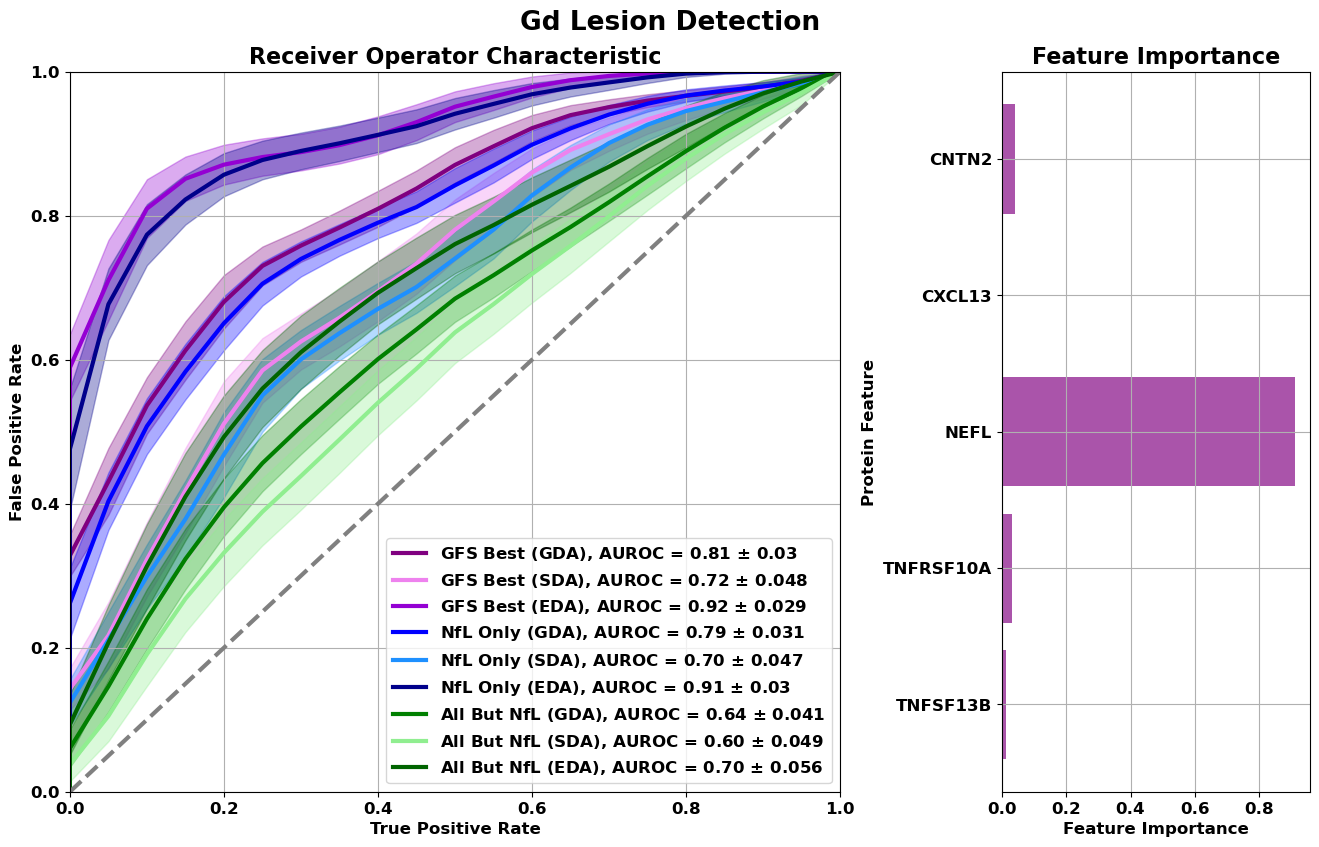

In [18]:
# Generate the ROCs.
gd_rocs = { feat_set: { da: [ get_roc( predictions.values, \
                                       labels[ da ].loc[ predictions.index ].values ) \
                              for predictions in gd_clas_predictions[ feat_set ][ da ] ]
                        for da in gd_clas_predictions[ feat_set ].keys() } \
            for feat_set in gd_clas_models.keys() }
# Aggregate them.
gd_roc_aggs = { feat_set: { da: aggregate_rocs( { "false_positives": [ roc[ "fals_pos" ] for roc in gd_rocs[ feat_set ][ da ] ], \
                                                   "true_positives": [ roc[ "true_pos" ] for roc in gd_rocs[ feat_set ][ da ] ], \
                                                            "auroc": [ roc[ "auroc"    ] for roc in gd_rocs[ feat_set ][ da ] ] } )
                            for da in gd_rocs[ feat_set ].keys() } \
                for feat_set in gd_rocs.keys() }
# Add a zero to the beginning and a one to the end (if there isn't already one).
for feat_set in gd_roc_aggs.keys():
   for da in gd_roc_aggs[ feat_set ].keys():
      if ( ( gd_roc_aggs[ feat_set ][ da ][ "false_positives"     ][ 0 ] != 0. ) | \
           ( gd_roc_aggs[ feat_set ][ da ][ "true_positives_mean" ][ 0 ] != 0. ) ):
         for vals in gd_roc_aggs[ feat_set ][ da ].keys():
            if vals != "aurocs":
               gd_roc_aggs[ feat_set ][ da ][ vals ] = np.concatenate( [ [ 0. ], gd_roc_aggs[ feat_set ][ da ][ vals ] ] )
      if ( ( gd_roc_aggs[ feat_set ][ da ][ "false_positives"     ][ -1 ] != 1. ) | \
           ( gd_roc_aggs[ feat_set ][ da ][ "true_positives_mean" ][ -1 ] != 1. ) ):
         for vals in gd_roc_aggs[ feat_set ][ da ].keys():
            if vals != "aurocs":
               gd_roc_aggs[ feat_set ][ da ][ vals ] = np.concatenate( [ gd_roc_aggs[ feat_set ][ da ][ vals ], [ 1. ] ] )
# Some plotting constants.
roc_colors = { "gfs_gd_clas": { "gda": "purple", "sda": "violet",     "eda": "darkviolet" }, \
                 "nefl_only": { "gda": "blue",   "sda": "dodgerblue", "eda": "darkblue" }, \
              "all_but_nefl": { "gda": "green",  "sda": "lightgreen", "eda": "darkgreen" } }
feature_set_names = { "gfs_gd_clas": "GFS Best", \
                        "nefl_only": "NfL Only", \
                     "all_but_nefl": "All But NfL" }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 2, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white", \
                              gridspec_kw = { "width_ratios": [ 2.5, 1. ] } )
# Plot the aggregated ROCs, and the uncertainty bands.
roc_plots = { feat_set: { da: [ sub_plot[ 0 ].plot( gd_roc_aggs[ feat_set ][ da ][ "false_positives" ], \
                                                    gd_roc_aggs[ feat_set ][ da ][ "true_positives_mean" ], \
                                                    "-", color = roc_colors[ feat_set ][ da ], linewidth = 3., \
                                                    label = "{:} ({:}), AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                              da.upper(), \
                                                                                                              gd_roc_aggs[ feat_set ][ da ][ "aurocs" ].mean(), \
                                                                                                              gd_roc_aggs[ feat_set ][ da ][ "aurocs" ].std() ) ), \
                                sub_plot[ 0 ].fill_between( gd_roc_aggs[ feat_set ][ da ][ "false_positives" ], \
                                                            gd_roc_aggs[ feat_set ][ da ][ "true_positives_mean" ] - ( 0.5 * gd_roc_aggs[ feat_set ][ da ][ "true_positives_stdv" ] ), \
                                                            gd_roc_aggs[ feat_set ][ da ][ "true_positives_mean" ] + ( 0.5 * gd_roc_aggs[ feat_set ][ da ][ "true_positives_stdv" ] ), \
                                                            color = roc_colors[ feat_set ][ da ], alpha = 0.33 ) ]
                          for da in gd_roc_aggs[ feat_set ].keys() } \
              for feat_set in gd_roc_aggs.keys() }
# Show the y = x line for perfect agreement.
sub_plot[ 0 ].plot( [ 0., 1. ], [ 0., 1. ], "--", color = "gray", linewidth = 3. )
# Plot the feature importance vector averaged over the bootstraps.
sub_plot[ 1 ].barh( np.arange( len( features[ "gfs_gd_clas" ] ) ), \
                    ( gd_clas_feat_imp.mean( axis = ( 0, 2 ) ) / gd_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    xerr = ( ( ( gd_clas_feat_imp.std( axis = 2 ) / \
                                 np.sqrt( n_permutations ) ).std( axis = 0 ) / \
                                 np.sqrt( n_bootstraps ) ) / \
                               gd_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    height = 0.8, align = "center", color = "purple", alpha = 0.67 )
# Formatting.
fig.suptitle( "Gd Lesion Detection", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.3, hspace = 0.05, top = 0.91 )
sub_plot[ 0 ].set_title( "Receiver Operator Characteristic", fontdict = title_font )
sub_plot[ 0 ].set_xlabel( "True Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_ylabel( "False Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_xlim( [ 0., 1. ] )
sub_plot[ 0 ].set_ylim( [ 0., 1. ] )
color_bar.set_label( "Number of Predictions", fontdict = fig_font )
sub_plot[ 0 ].legend( loc = "lower right" )
sub_plot[ 1 ].set_title( "Feature Importance", fontdict = title_font )
sub_plot[ 1 ].set_xlabel( "Feature Importance", fontdict = fig_font )
sub_plot[ 1 ].set_ylabel( "Protein Feature", fontdict = fig_font )
sub_plot[ 1 ].set_yticks( np.arange( len( features[ "gfs_gd_clas" ] ) ) )
sub_plot[ 1 ].set_yticklabels( [ feat.upper() for feat in features[ "gfs_gd_clas" ][ ::-1 ] ], \
                               fontdict = fig_font )
for sp in sub_plot:
    sp.grid( True )

Great. We're going to tabulate all of these, and save a few of them for a summary plot. Now, the...

## Clinical relapse status (CRS)
...should be a little simpler than Gd lesion detection since there is only one version of this endpoint.

In [19]:
# Specify the configuration for this model.
crs_clas_model_config = { "model_type": "LogRegr", \
                                "dual": False, \
                       "fit_intercept": True, \
                         "multi_class": "auto", \
                            "max_iter": 500, \
                              "n_jobs": -1, \
                        "class_weight": "balanced", \
                              "solver": "saga", \
                             "penalty": "elasticnet", \
                                   "C": 0.1, \
                                 "tol": 0.005, \
                            "l1_ratio": 0.1 }

# Initialize arrays to hold the: models, predictions, and AUROC values for each bootstrap.
crs_clas_models, crs_clas_predictions, crs_clas_auroc_vals = { feat_set: [] for feat_set in [ "gfs_crs_clas", "nefl_only", "all_but_nefl" ] }, \
                                                             { feat_set: [] for feat_set in [ "gfs_crs_clas", "nefl_only", "all_but_nefl" ] }, \
                                                             { feat_set: [] for feat_set in [ "gfs_crs_clas", "nefl_only", "all_but_nefl" ] }
# Iterate over the feature sets for this analysis.
for feat_set in crs_clas_models.keys():
      print( "{:} Features...".format( feat_set) )
      # Set up a progress bar to track our progress.
      with tqdm( total = n_bootstraps, \
                  desc = "Training CRS Classification models" ) \
            as pbar:
            # Create and train the models.
            crs_clas_models[ feat_set ] = [ train_model( create_model( model_type = crs_clas_model_config[ "model_type" ], config = crs_clas_model_config ), \
                                                         feature_data[ "crs" ].loc[ tr_spl ][ features[ feat_set ] ].values.astype( np.float64 ), \
                                                               labels[ "crs" ].loc[ tr_spl ].values.astype( np.float64 ), \
                                                         scaling = False, progress = pbar )  \
                                           for tr_spl in train_splits[ "crs" ] ]
      # Make predictions for each model trained on one of our training splits.
      with tqdm( total = n_bootstraps, \
                  desc = "Predicting clinical relapse status" ) \
            as pbar:
            for model, te_spl in zip( crs_clas_models[ feat_set ], test_splits[ "crs" ] ):
                  # ...isolate the non-nan rows in the data and the labels across the test splits.
                  non_nan_rows = ( ( ~feature_data[ "crs" ][ features[ feat_set ] ].isna().any( axis = 1 ) ) & ( ~labels[ "crs" ].isna() ) )
                  non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
                  # Generate predictions for this model/test split.
                  crs_clas_predictions[ feat_set ].append( pd.Series( model.predict_proba( feature_data[ "crs" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ features[ feat_set ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                                      index = list( set( te_spl ).intersection( non_nan_rows ) ) ) )
                  # Iterate the progress bar.
                  pbar.update( 1 )
      # Evaluate the predictions we just made..
      with tqdm( total = n_bootstraps, \
                  desc = "Evaluating CRS predictions" ) \
            as pbar:
            for predictions in crs_clas_predictions[ feat_set ]:
                  # Evaluate the predictions for this model/test split.
                  crs_clas_auroc_vals[ feat_set ].append( roc_auc_score( labels[ "crs" ].loc[ predictions.index ].values, \
                                                                         predictions.values ) )
                  # Iterate the progress bar.
                  pbar.update( 1 )

gfs_crs_clas Features...


Evaluating CRS predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3620.28it/s]


nefl_only Features...


Evaluating CRS predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3605.23it/s]


all_but_nefl Features...


Evaluating CRS predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3566.66it/s]


In [20]:
# Initialize a list to store the feature importance vectors
crs_clas_feat_imp = []
# Set up a progress bar to track our progress.
with tqdm( total = n_bootstraps, \
            desc = "Extract feature importance vectors" ) \
    as pbar:
    # Iterate over the models and the data used to train them.
    for model, tr_split in zip( crs_clas_models[ "gfs_crs_clas" ], train_splits[ "crs" ] ):
        # Extract the feature importance vector using permutations.
        crs_clas_feat_imp.append( get_feature_importance_from_permutations( model, \
                                                                            feature_data[ "crs" ].loc[ tr_split ][ features[ "gfs_crs_clas" ] ], \
                                                                                  labels[ "crs" ].loc[ tr_split ], \
                                                                            n_rounds = n_permutations, classification = True, metric = "auroc", softmax = True ) )
        # Iterate the progress bar.
        pbar.update( 1 )
# Rebundle these into a nice happy numpy array.
crs_clas_feat_imp = np.concatenate( [ feat_imps.reshape( n_permutations, \
                                                         len( features[ "gfs_crs_clas" ] ), \
                                                         1 ) \
                                      for feat_imps in crs_clas_feat_imp ], \
                                    axis = 2 )

Extract feature importance vectors: 100%|██████████| 1000/1000 [02:18<00:00,  7.21it/s]


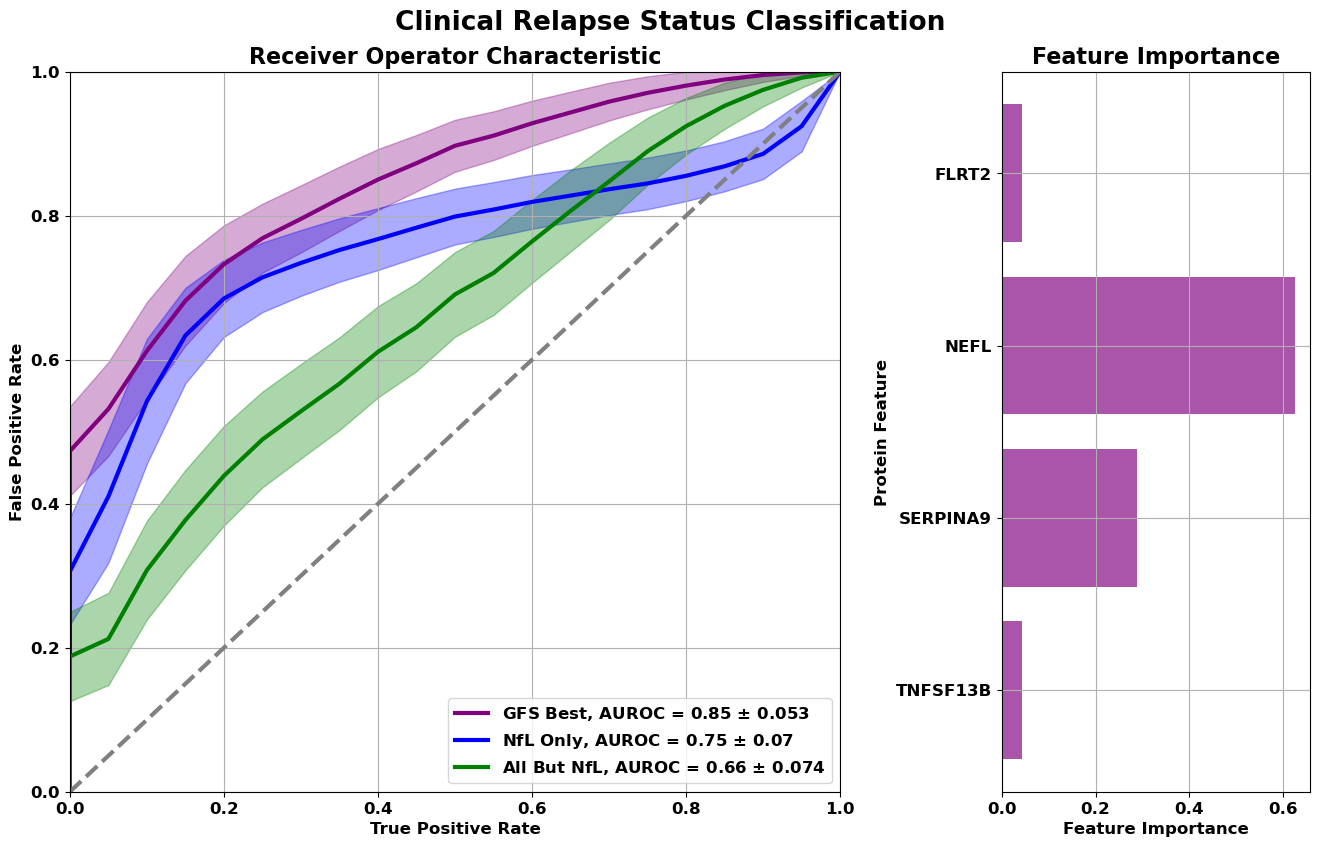

In [21]:
# Generate the ROCs.
crs_rocs = { feat_set: [ get_roc( predictions.values, \
                                  labels[ "crs" ].loc[ predictions.index ].values ) \
                         for predictions in crs_clas_predictions[ feat_set ] ]
             for feat_set in crs_clas_models.keys() }
# Aggregate them.
crs_roc_aggs = { feat_set: aggregate_rocs( { "false_positives": [ roc[ "fals_pos" ] for roc in crs_rocs[ feat_set ] ], \
                                              "true_positives": [ roc[ "true_pos" ] for roc in crs_rocs[ feat_set ] ], \
                                                       "auroc": [ roc[ "auroc"    ] for roc in crs_rocs[ feat_set ] ] } )
                 for feat_set in crs_rocs.keys() }
# Add a zero to the beginning and a one to the end (if there isn't already one).
for feat_set in crs_roc_aggs.keys():
    if ( ( crs_roc_aggs[ feat_set ][ "false_positives"     ][ 0 ] != 0. ) | \
         ( crs_roc_aggs[ feat_set ][ "true_positives_mean" ][ 0 ] != 0. ) ):
        for vals in crs_roc_aggs[ feat_set ].keys():
            if vals != "aurocs":
                crs_roc_aggs[ feat_set ][ vals ] = np.concatenate( [ [ 0. ], crs_roc_aggs[ feat_set ][ vals ] ] )
    if ( ( crs_roc_aggs[ feat_set ][ "false_positives"     ][ -1 ] != 1. ) | \
         ( crs_roc_aggs[ feat_set ][ "true_positives_mean" ][ -1 ] != 1. ) ):
        for vals in crs_roc_aggs[ feat_set ].keys():
            if vals != "aurocs":
                crs_roc_aggs[ feat_set ][ vals ] = np.concatenate( [ crs_roc_aggs[ feat_set ][ vals ], [ 1. ] ] )
# Some plotting constants.
roc_colors = { "gfs_crs_clas": "purple", \
                  "nefl_only": "blue", \
               "all_but_nefl": "green" }
feature_set_names = { "gfs_crs_clas": "GFS Best", \
                         "nefl_only": "NfL Only", \
                      "all_but_nefl": "All But NfL" }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 2, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white", \
                              gridspec_kw = { "width_ratios": [ 2.5, 1. ] } )
# Plot the aggregated ROCs, and the uncertainty bands.
roc_plots = { feat_set: [ sub_plot[ 0 ].plot( crs_roc_aggs[ feat_set ][ "false_positives" ], \
                                              crs_roc_aggs[ feat_set ][ "true_positives_mean" ], \
                                              "-", color = roc_colors[ feat_set ], linewidth = 3., \
                                              label = "{:}, AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                  crs_roc_aggs[ feat_set ][ "aurocs" ].mean(), \
                                                                                                  crs_roc_aggs[ feat_set ][ "aurocs" ].std() ) ), \
                          sub_plot[ 0 ].fill_between( crs_roc_aggs[ feat_set ][ "false_positives" ], \
                                                      crs_roc_aggs[ feat_set ][ "true_positives_mean" ] - ( 0.5 * crs_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                      crs_roc_aggs[ feat_set ][ "true_positives_mean" ] + ( 0.5 * crs_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                      color = roc_colors[ feat_set ], alpha = 0.33 ) ]
              for feat_set in crs_roc_aggs.keys() }
# Show the y = x line for perfect agreement.
sub_plot[ 0 ].plot( [ 0., 1. ], [ 0., 1. ], "--", color = "gray", linewidth = 3. )
# Plot the feature importance vector averaged over the bootstraps.
sub_plot[ 1 ].barh( np.arange( len( features[ "gfs_crs_clas" ] ) ), \
                    ( crs_clas_feat_imp.mean( axis = ( 0, 2 ) ) / crs_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    xerr = ( ( ( crs_clas_feat_imp.std( axis = 2 ) / \
                                 np.sqrt( n_permutations ) ).std( axis = 0 ) / \
                                 np.sqrt( n_bootstraps ) ) / \
                               crs_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    height = 0.8, align = "center", color = "purple", alpha = 0.67 )
# Formatting.
fig.suptitle( "Clinical Relapse Status Classification", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.3, hspace = 0.05, top = 0.91 )
sub_plot[ 0 ].set_title( "Receiver Operator Characteristic", fontdict = title_font )
sub_plot[ 0 ].set_xlabel( "True Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_ylabel( "False Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_xlim( [ 0., 1. ] )
sub_plot[ 0 ].set_ylim( [ 0., 1. ] )
color_bar.set_label( "Number of Predictions", fontdict = fig_font )
sub_plot[ 0 ].legend( loc = "lower right" )
sub_plot[ 1 ].set_title( "Feature Importance", fontdict = title_font )
sub_plot[ 1 ].set_xlabel( "Feature Importance", fontdict = fig_font )
sub_plot[ 1 ].set_ylabel( "Protein Feature", fontdict = fig_font )
sub_plot[ 1 ].set_yticks( np.arange( len( features[ "gfs_crs_clas" ] ) ) )
sub_plot[ 1 ].set_yticklabels( [ feat.upper() for feat in features[ "gfs_crs_clas" ][ ::-1 ] ], \
                               fontdict = fig_font )
for sp in sub_plot:
    sp.grid( True )

OK, and now, the...
## Annualized relapse rate  classification

In [22]:
# Specify the configuration for this model.
arr_clas_model_config = { "model_type": "LogRegr", \
                                "dual": False, \
                       "fit_intercept": True, \
                         "multi_class": "auto", \
                            "max_iter": 1000000, \
                              "n_jobs": -1, \
                        "class_weight": "balanced", \
                              "solver": "saga", \
                             "penalty": "elasticnet", \
                                   "C": 0.1, \
                                 "tol": 0.05, \
                            "l1_ratio": 0.1 }

# Initialize arrays to hold the: models, predictions, and AUROC values for each bootstrap.
arr_clas_models, arr_clas_predictions, arr_clas_auroc_vals = { feat_set: [] for feat_set in [ "gfs_arr_clas", "nefl_only", "all_but_nefl" ] }, \
                                                             { feat_set: [] for feat_set in [ "gfs_arr_clas", "nefl_only", "all_but_nefl" ] }, \
                                                             { feat_set: [] for feat_set in [ "gfs_arr_clas", "nefl_only", "all_but_nefl" ] }
# Iterate over the feature sets for this analysis.
for feat_set in arr_clas_models.keys():
      print( "{:} Features...".format( feat_set) )
      # Set up a progress bar to track our progress.
      with tqdm( total = n_bootstraps, \
                  desc = "Training ARR Classification models" ) \
            as pbar:
            # Create and train the models.
            arr_clas_models[ feat_set ] = [ train_model( create_model( model_type = arr_clas_model_config[ "model_type" ], config = arr_clas_model_config ), \
                                                         feature_data[ "arr" ].loc[ tr_spl ][ features[ feat_set ] ].values.astype( np.float64 ), \
                                                               labels[ "arr" ].loc[ tr_spl ].values.astype( np.float64 ), \
                                                         scaling = False, progress = pbar )  \
                                           for tr_spl in train_splits[ "arr" ] ]
      # Make predictions for each model trained on one of our training splits.
      with tqdm( total = n_bootstraps, \
                  desc = "Predicting annualized relapse rate status" ) \
            as pbar:
            for model, te_spl in zip( arr_clas_models[ feat_set ], test_splits[ "arr" ] ):
                  # ...isolate the non-nan rows in the data and the labels across the test splits.
                  non_nan_rows = ( ( ~feature_data[ "arr" ][ features[ feat_set ] ].isna().any( axis = 1 ) ) & ( ~labels[ "arr" ].isna() ) )
                  non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
                  # Generate predictions for this model/test split.
                  arr_clas_predictions[ feat_set ].append( pd.Series( model.predict_proba( feature_data[ "arr" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ features[ feat_set ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                                      index = list( set( te_spl ).intersection( non_nan_rows ) ) ) )
                  # Iterate the progress bar.
                  pbar.update( 1 )
      # Evaluate the predictions we just made..
      with tqdm( total = n_bootstraps, \
                  desc = "Evaluating ARR predictions" ) \
            as pbar:
            for predictions in arr_clas_predictions[ feat_set ]:
                  # Evaluate the predictions for this model/test split.
                  arr_clas_auroc_vals[ feat_set ].append( roc_auc_score( labels[ "arr" ].loc[ predictions.index ].values, \
                                                                         predictions.values ) )
                  # Iterate the progress bar.
                  pbar.update( 1 )

gfs_arr_clas Features...


Evaluating ARR predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3473.67it/s]


nefl_only Features...


Evaluating ARR predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3350.97it/s]


all_but_nefl Features...


Evaluating ARR predictions: 100%|██████████| 1000/1000 [00:00<00:00, 3482.22it/s]


In [23]:
# Initialize a list to store the feature importance vectors
arr_clas_feat_imp = []
# Set up a progress bar to track our progress.
with tqdm( total = n_bootstraps, \
            desc = "Extract feature importance vectors" ) \
    as pbar:
    # Iterate over the models and the data used to train them.
    for model, tr_split in zip( arr_clas_models[ "gfs_arr_clas" ], train_splits[ "arr" ] ):
        # Extract the feature importance vector using permutations.
        arr_clas_feat_imp.append( get_feature_importance_from_permutations( model, \
                                                                            feature_data[ "arr" ].loc[ tr_split ][ features[ "gfs_arr_clas" ] ], \
                                                                                  labels[ "arr" ].loc[ tr_split ], \
                                                                            n_rounds = n_permutations, classification = True, metric = "auroc", softmax = True ) )
        # Iterate the progress bar.
        pbar.update( 1 )
# Rebundle these into a nice happy numpy array.
arr_clas_feat_imp = np.concatenate( [ feat_imps.reshape( n_permutations, \
                                                         len( features[ "gfs_arr_clas" ] ), \
                                                         1 ) \
                                      for feat_imps in arr_clas_feat_imp ], \
                                    axis = 2 )

Extract feature importance vectors: 100%|██████████| 1000/1000 [01:35<00:00, 10.49it/s]


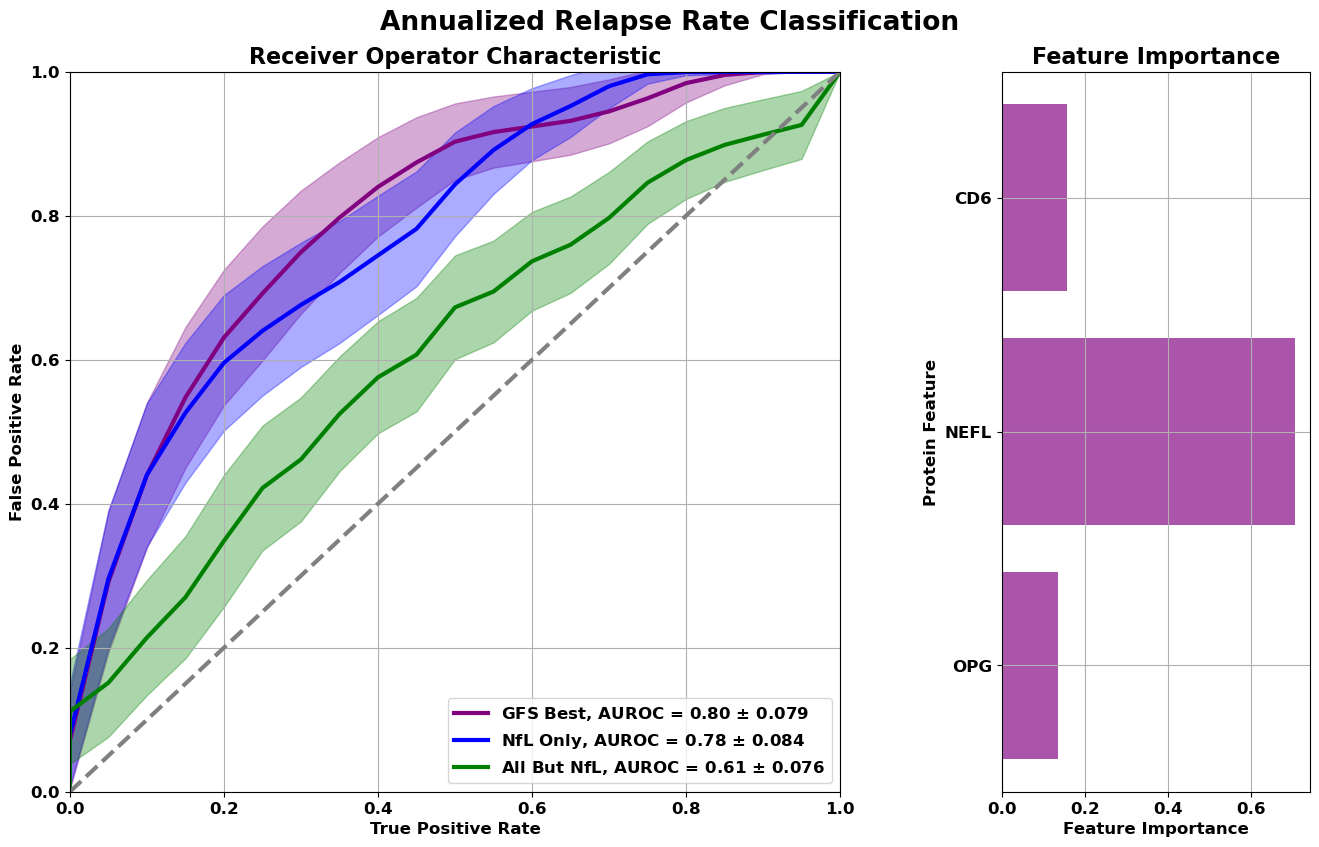

In [24]:
# Generate the ROCs.
arr_rocs = { feat_set: [ get_roc( predictions.values, \
                                  labels[ "arr" ].loc[ predictions.index ].values ) \
                         for predictions in arr_clas_predictions[ feat_set ] ]
             for feat_set in arr_clas_models.keys() }
# Aggregate them.
arr_roc_aggs = { feat_set: aggregate_rocs( { "false_positives": [ roc[ "fals_pos" ] for roc in arr_rocs[ feat_set ] ], \
                                              "true_positives": [ roc[ "true_pos" ] for roc in arr_rocs[ feat_set ] ], \
                                                       "auroc": [ roc[ "auroc"    ] for roc in arr_rocs[ feat_set ] ] } )
                 for feat_set in arr_rocs.keys() }
# Add a zero to the beginning and a one to the end (if there isn't already one).
for feat_set in arr_roc_aggs.keys():
    if ( ( arr_roc_aggs[ feat_set ][ "false_positives"     ][ 0 ] != 0. ) | \
         ( arr_roc_aggs[ feat_set ][ "true_positives_mean" ][ 0 ] != 0. ) ):
        for vals in arr_roc_aggs[ feat_set ].keys():
            if vals != "aurocs":
                arr_roc_aggs[ feat_set ][ vals ] = np.concatenate( [ [ 0. ], arr_roc_aggs[ feat_set ][ vals ] ] )
    if ( ( arr_roc_aggs[ feat_set ][ "false_positives"     ][ -1 ] != 1. ) | \
         ( arr_roc_aggs[ feat_set ][ "true_positives_mean" ][ -1 ] != 1. ) ):
        for vals in arr_roc_aggs[ feat_set ].keys():
            if vals != "aurocs":
                arr_roc_aggs[ feat_set ][ vals ] = np.concatenate( [ arr_roc_aggs[ feat_set ][ vals ], [ 1. ] ] )
# Some plotting constants.
roc_colors = { "gfs_arr_clas": "purple", \
                  "nefl_only": "blue", \
               "all_but_nefl": "green" }
feature_set_names = { "gfs_arr_clas": "GFS Best", \
                         "nefl_only": "NfL Only", \
                      "all_but_nefl": "All But NfL" }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 2, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white", \
                              gridspec_kw = { "width_ratios": [ 2.5, 1. ] } )
# Plot the aggregated ROCs, and the uncertainty bands.
roc_plots = { feat_set: [ sub_plot[ 0 ].plot( arr_roc_aggs[ feat_set ][ "false_positives" ], \
                                              arr_roc_aggs[ feat_set ][ "true_positives_mean" ], \
                                              "-", color = roc_colors[ feat_set ], linewidth = 3., \
                                              label = "{:}, AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                  arr_roc_aggs[ feat_set ][ "aurocs" ].mean(), \
                                                                                                  arr_roc_aggs[ feat_set ][ "aurocs" ].std() ) ), \
                          sub_plot[ 0 ].fill_between( arr_roc_aggs[ feat_set ][ "false_positives" ], \
                                                      arr_roc_aggs[ feat_set ][ "true_positives_mean" ] - ( 0.5 * arr_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                      arr_roc_aggs[ feat_set ][ "true_positives_mean" ] + ( 0.5 * arr_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                      color = roc_colors[ feat_set ], alpha = 0.33 ) ]
              for feat_set in arr_roc_aggs.keys() }
# Show the y = x line for perfect agreement.
sub_plot[ 0 ].plot( [ 0., 1. ], [ 0., 1. ], "--", color = "gray", linewidth = 3. )
# Plot the feature importance vector averaged over the bootstraps.
sub_plot[ 1 ].barh( np.arange( len( features[ "gfs_arr_clas" ] ) ), \
                    ( arr_clas_feat_imp.mean( axis = ( 0, 2 ) ) / arr_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    xerr = ( ( ( arr_clas_feat_imp.std( axis = 2 ) / \
                                 np.sqrt( n_permutations ) ).std( axis = 0 ) / \
                                 np.sqrt( n_bootstraps ) ) / \
                               arr_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() )[ ::-1 ], \
                    height = 0.8, align = "center", color = "purple", alpha = 0.67 )
# Formatting.
fig.suptitle( "Annualized Relapse Rate Classification", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.3, hspace = 0.05, top = 0.91 )
sub_plot[ 0 ].set_title( "Receiver Operator Characteristic", fontdict = title_font )
sub_plot[ 0 ].set_xlabel( "True Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_ylabel( "False Positive Rate", fontdict = fig_font )
sub_plot[ 0 ].set_xlim( [ 0., 1. ] )
sub_plot[ 0 ].set_ylim( [ 0., 1. ] )
color_bar.set_label( "Number of Predictions", fontdict = fig_font )
sub_plot[ 0 ].legend( loc = "lower right" )
sub_plot[ 1 ].set_title( "Feature Importance", fontdict = title_font )
sub_plot[ 1 ].set_xlabel( "Feature Importance", fontdict = fig_font )
sub_plot[ 1 ].set_ylabel( "Protein Feature", fontdict = fig_font )
sub_plot[ 1 ].set_yticks( np.arange( len( features[ "gfs_arr_clas" ] ) ) )
sub_plot[ 1 ].set_yticklabels( [ feat.upper() for feat in features[ "gfs_arr_clas" ][ ::-1 ] ], \
                               fontdict = fig_font )
for sp in sub_plot:
    sp.grid( True )

## Summary plots for the paper.
We don't have enough space in the paper for a separate figure for each analysis, so we're going to have to wrap up the multivariate analysis results into one.

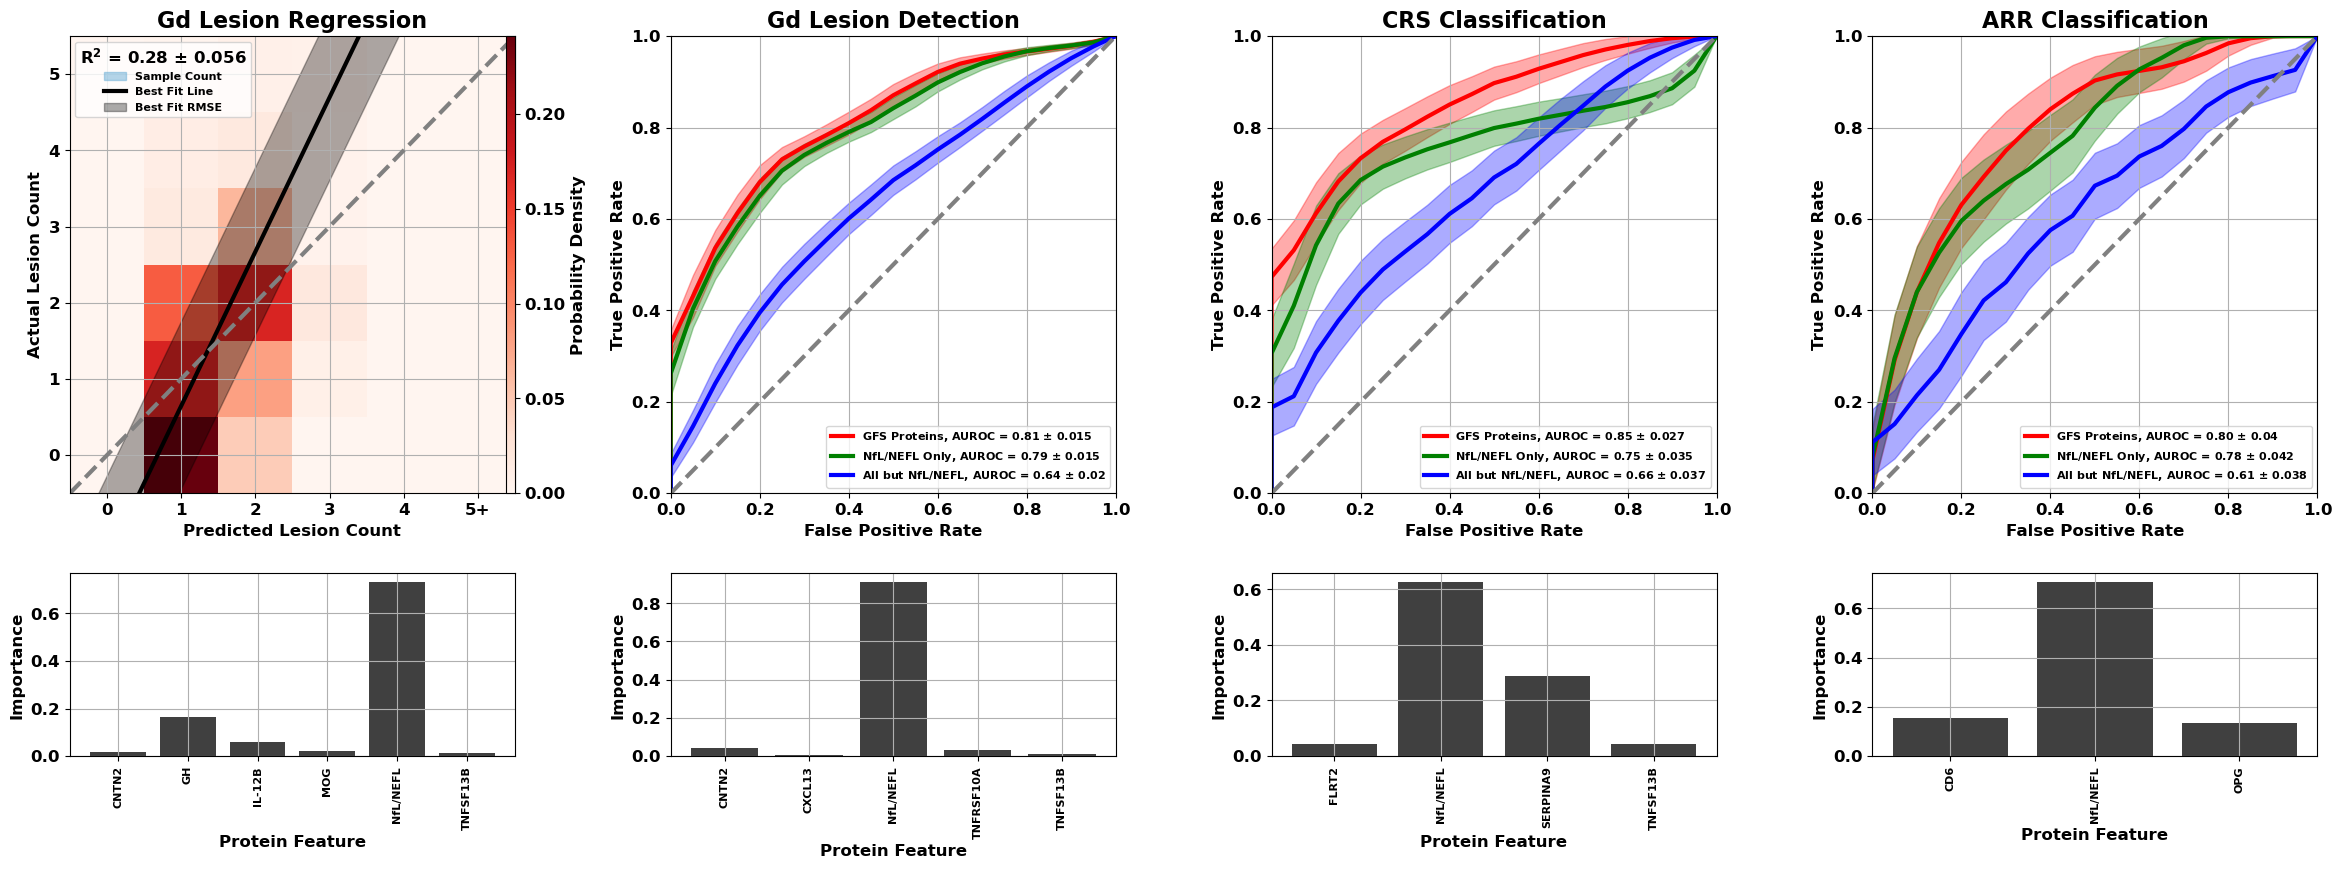

In [50]:
# Some plotting constants.
feature_set_colors = { feat_set: "green" if feat_set == "nefl_only" else \
                                 "blue" if feat_set == "all_but_nefl" else \
                                 "red"
                       for feat_set in features.keys() }
feature_set_names = { feat_set: "NfL/NEFL Only" if feat_set == "nefl_only" else \
                                 "All but NfL/NEFL" if feat_set == "all_but_nefl" else \
                                 "GFS Proteins"
                      for feat_set in features.keys() }
analysis_names = { "gfs_gd_regr": "Gd Lesion Regression", \
                   "gfs_gd_clas": "Gd Lesion Detection", \
                  "gfs_crs_clas": "CRS Classification", \
                  "gfs_arr_clas": "ARR Classification" }
line_width, band_alpha, ref_line_color = 3., 0.33, "gray"
# Create the figure--a large plot for each analysis and a smaller one for the feature importance vectors.
fig, sub_plot = plt.subplots( 2, 4, figsize = ( 29., 9. ), facecolor = "white", edgecolor = "white", \
                              gridspec_kw = { "height_ratios": [ 2.5, 1. ] } )
# Add the Gd lesion regression performance plot....
gd_regr_lesion_count_histo = sub_plot[ 0, 0 ].hist2d( np.concatenate( [ predictions.values.astype( np.float64 ) \
                                                                        for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                                      np.concatenate( [ labels[ "gd" ].loc[ predictions.index ].values.astype( np.float64 ) \
                                                                         for predictions in gd_regr_predictions[ "gfs_gd_regr" ] ] ), \
                                                      [ lesion_count_bins, lesion_count_bins ], density = True, cmap = "Reds", alpha = 1. )
gd_regr_best_fit_line = sub_plot[ 0, 0 ].plot( lesion_count_bins, \
                                               ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept, \
                                               "-", color = "black", linewidth = line_width )
gd_regr_best_fit_error = sub_plot[ 0, 0 ].fill_between( lesion_count_bins, \
                                                        ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept - ( 0.5 * gd_regr_rmse ), \
                                                        ( gd_regr_lin_regr.slope * lesion_count_bins ) + gd_regr_lin_regr.intercept + ( 0.5 * gd_regr_rmse ), \
                                                        color = "black", alpha = band_alpha )
gd_regr_perfect_agreement = sub_plot[ 0, 0 ].plot( lesion_count_bins, lesion_count_bins, "--", color = ref_line_color, linewidth = line_width )
# ...the Gd lesion detection performance plot...
gd_clas_roc_plots = { feat_set: [ sub_plot[ 0, 1 ].plot( gd_roc_aggs[ feat_set ][ "gda" ][ "false_positives" ], \
                                                         gd_roc_aggs[ feat_set ][ "gda" ][ "true_positives_mean" ], \
                                                         "-", color = feature_set_colors[ feat_set ], linewidth = line_width, \
                                                         label = "{:}, AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                             gd_roc_aggs[ feat_set ][ "gda" ][ "aurocs" ].mean(), \
                                                                                                       0.5 * gd_roc_aggs[ feat_set ][ "gda" ][ "aurocs" ].std() ) ), \
                                sub_plot[ 0, 1 ].fill_between( gd_roc_aggs[ feat_set ][ "gda" ][ "false_positives" ], \
                                                               gd_roc_aggs[ feat_set ][ "gda" ][ "true_positives_mean" ] - ( 0.5 * gd_roc_aggs[ feat_set ][ "gda" ][ "true_positives_stdv" ] ), \
                                                               gd_roc_aggs[ feat_set ][ "gda" ][ "true_positives_mean" ] + ( 0.5 * gd_roc_aggs[ feat_set ][ "gda" ][ "true_positives_stdv" ] ), \
                                                               color = feature_set_colors[ feat_set ], alpha = band_alpha ) ]
                      for feat_set in gd_roc_aggs.keys() }
# ...the CRS classifier performance...
crs_roc_plots = { feat_set: [ sub_plot[ 0, 2 ].plot( crs_roc_aggs[ feat_set ][ "false_positives" ], \
                                                     crs_roc_aggs[ feat_set ][ "true_positives_mean" ], \
                                                     "-", color = feature_set_colors[ feat_set ], linewidth = line_width, \
                                                     label = "{:}, AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                         crs_roc_aggs[ feat_set ][ "aurocs" ].mean(), \
                                                                                                   0.5 * crs_roc_aggs[ feat_set ][ "aurocs" ].std() ) ), \
                              sub_plot[ 0, 2 ].fill_between( crs_roc_aggs[ feat_set ][ "false_positives" ], \
                                                             crs_roc_aggs[ feat_set ][ "true_positives_mean" ] - ( 0.5 * crs_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                             crs_roc_aggs[ feat_set ][ "true_positives_mean" ] + ( 0.5 * crs_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                             color = feature_set_colors[ feat_set ], alpha = band_alpha ) ]
                  for feat_set in crs_roc_aggs.keys() }
# ...and the ARR classifier performance.
arr_roc_plots = { feat_set: [ sub_plot[ 0, 3 ].plot( arr_roc_aggs[ feat_set ][ "false_positives" ], \
                                                     arr_roc_aggs[ feat_set ][ "true_positives_mean" ], \
                                                     "-", color = feature_set_colors[ feat_set ], linewidth = line_width, \
                                                     label = "{:}, AUROC = {:1.2f} $\pm$ {:1.2}".format( feature_set_names[ feat_set ], \
                                                                                                         arr_roc_aggs[ feat_set ][ "aurocs" ].mean(), \
                                                                                                   0.5 * arr_roc_aggs[ feat_set ][ "aurocs" ].std() ) ), \
                          sub_plot[ 0, 3 ].fill_between( arr_roc_aggs[ feat_set ][ "false_positives" ], \
                                                         arr_roc_aggs[ feat_set ][ "true_positives_mean" ] - ( 0.5 * arr_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                         arr_roc_aggs[ feat_set ][ "true_positives_mean" ] + ( 0.5 * arr_roc_aggs[ feat_set ][ "true_positives_stdv" ] ), \
                                                         color = feature_set_colors[ feat_set ], alpha = band_alpha ) ]
                  for feat_set in arr_roc_aggs.keys() }
# Show the y = x line for perfect agreement for all the ROCs.
for sp in sub_plot[ 0, 1: ]:
    sp.plot( [ 0., 1. ], [ 0., 1. ], "--", color = ref_line_color, linewidth = line_width )
# Plot all the feature importance vectors in the bottom row.
for sp, feat_set, feat_imp in zip( sub_plot[ 1, : ], \
                                   [ "gfs_gd_regr", "gfs_gd_clas", "gfs_crs_clas", "gfs_arr_clas" ], \
                                   [ gd_regr_feat_imp, gd_clas_feat_imp, crs_clas_feat_imp,  arr_clas_feat_imp ] ):
    sp.bar( np.arange( len( features[ feat_set ] ) ), \
            ( feat_imp.mean( axis = ( 0, 2 ) ) / feat_imp.mean( axis = ( 0, 2 ) ).sum() ), \
            yerr = ( 0.5 * ( ( feat_imp.std( axis = 2 ) / np.sqrt( n_permutations ) ).std( axis = 0 ) / np.sqrt( n_bootstraps ) ) / feat_imp.mean( axis = ( 0, 2 ) ).sum() ), \
            width = 0.8, align = "center", color = "black", alpha = 0.75 )
# Formatting.
plt.subplots_adjust( wspace = 0.35, hspace = 0.25, top = 0.91 )
for sp, analsyis_name in zip( sub_plot.ravel(), 2 * list( analysis_names.keys() ) ):
    # Top row...
    if sp in sub_plot[ 0, : ]:
        sp.set_title( analysis_names[ analsyis_name ], fontdict = title_font )
        if sp == sub_plot[ 0, 0 ]:
            sp.set_xlabel( "Predicted Lesion Count", fontdict = fig_font )
            sp.set_ylabel( "Actual Lesion Count", fontdict = fig_font )
            sp.set_xlim( [ lesion_count_bins.min(), lesion_count_bins.max() ] )
            sp.set_ylim( [ lesion_count_bins.min(), lesion_count_bins.max() ] )
            sp.set_xticks( np.arange( gd_clip_lim + 1. ) )
            sp.set_xticklabels( [ "{:d}+".format( int( gd ) ) if gd == 5. else \
                                  "{:d}".format( int( gd ) ) \
                                  for gd in np.arange( gd_clip_lim + 1. ) ], fontdict = fig_font )
            color_bar = fig.colorbar( gd_regr_lesion_count_histo[ -1 ], \
                                      cax = sp.inset_axes( bounds = [ 0.98, 0., 0.02, 1. ] ) )
            color_bar.ax.set_yticks( np.arange( 0., 0.201, 0.05 ) )
            color_bar.set_label( "Probability Density", fontdict = fig_font )
            sp.legend( [ mpatches.Patch( color = matplotlib.cm.Blues( 0.5 ), alpha = 0.5 ), \
                         matplotlib.lines.Line2D( [ 0 ],[ 0 ], color = "black", linewidth = line_width ), \
                         mpatches.Patch( color = "black", alpha = band_alpha ) ], \
                       [ "Sample Count", "Best Fit Line", "Best Fit RMSE" ], \
                       title = "R$^2$ = {:1.2} $\pm$ {:1.2}".format( np.mean( gd_regr_r2_vals[ "gfs_gd_regr" ] ), \
                                                                     np.std(  gd_regr_r2_vals[ "gfs_gd_regr" ] ) ), \
                       loc = "upper left", fontsize = small_font[ "size" ] )
        else:
            sp.set_ylabel( "True Positive Rate", fontdict = fig_font )
            sp.set_xlabel( "False Positive Rate", fontdict = fig_font )
            sp.set_xlim( [ 0., 1. ] )
            sp.set_ylim( [ 0., 1. ] )
            sp.legend( loc = "lower right", fontsize = small_font[ "size" ] )
    # Bottom row...
    else:
        sp.set_xlabel( "Protein Feature", fontdict = fig_font )
        sp.set_ylabel( "Importance", fontdict = fig_font )
        sp.set_xticks( np.arange( len( features[ analsyis_name ] ) ) )
        sp.set_xticklabels( [ "NfL/NEFL" if feat == "nefl" else \
                              feat.upper() \
                              for feat in features[ analsyis_name ] ], \
                            rotation = 90., fontdict = small_font )
    sp.grid( True )
plt.savefig( "./latex/figures/multivar_all_endopints.pdf", dpi = 300., bbox_inches = "tight" )
plt.savefig( "./latex/figures/multivar_all_endopints.png", dpi = 300., bbox_inches = "tight" )

## Summary table for the paper...
The real one will be nice and `LaTeX`y, but this one will have all the data in one place.

In [26]:
pd.DataFrame( { "GFS Opt.": [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_regr_r2_vals[ "gfs_gd_regr" ] ),  0.5 * np.std( gd_regr_r2_vals[ "gfs_gd_regr" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_clas_auroc_vals[ "gfs_gd_clas" ][ da ] ),  \
                                                      0.5 * np.std(  gd_clas_auroc_vals[ "gfs_gd_clas" ][ da ] ) ) \
                              for da in gd_clas_auroc_vals[ "gfs_gd_clas" ].keys() ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( crs_clas_auroc_vals[ "gfs_crs_clas" ] ),  0.5 * np.std( crs_clas_auroc_vals[ "gfs_crs_clas" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( arr_clas_auroc_vals[ "gfs_arr_clas" ] ),  0.5 * np.std( arr_clas_auroc_vals[ "gfs_arr_clas" ] ) ) ], \
                "NfL Only": [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_regr_r2_vals[ "nefl_only" ] ),    0.5 * np.std( gd_regr_r2_vals[ "nefl_only" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_clas_auroc_vals[ "nefl_only" ][ da ] ),  \
                                                      0.5 * np.std(  gd_clas_auroc_vals[ "nefl_only" ][ da ] ) ) \
                              for da in gd_clas_auroc_vals[ "nefl_only" ].keys() ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( crs_clas_auroc_vals[ "nefl_only" ] ),  0.5 * np.std( crs_clas_auroc_vals[ "nefl_only" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( arr_clas_auroc_vals[ "nefl_only" ] ),  0.5 * np.std( arr_clas_auroc_vals[ "nefl_only" ] ) ) ], \
             "All but NfL": [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_regr_r2_vals[ "all_but_nefl" ] ), 0.5 * np.std( gd_regr_r2_vals[ "all_but_nefl" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( gd_clas_auroc_vals[ "all_but_nefl" ][ da ] ),  \
                                                      0.5 * np.std(  gd_clas_auroc_vals[ "all_but_nefl" ][ da ] ) ) \
                              for da in gd_clas_auroc_vals[ "all_but_nefl" ].keys() ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( crs_clas_auroc_vals[ "all_but_nefl" ] ),  0.5 * np.std( crs_clas_auroc_vals[ "all_but_nefl" ] ) ) ] + \
                            [ "{:1.3f} +/- {:1.3f}".format( np.mean( arr_clas_auroc_vals[ "all_but_nefl" ] ),  0.5 * np.std( arr_clas_auroc_vals[ "all_but_nefl" ] ) ) ] }, \
              index = [ "Gd Les. Regr. (R^2)", "GDA Stat. (AUROC)", "SDA Stat. (AUROC)", "EDA Stat. (AUROC)", "Clin. Rel. Stat. (AUROC)", "Ann. Rel. Rate Stat. (AUROC)"  ] )

,GFS Opt.,NfL Only,All but NfL
Gd Les. Regr. (R^2),0.284 +/- 0.028,0.237 +/- 0.029,0.072 +/- 0.018
GDA Stat. (AUROC),0.813 +/- 0.015,0.795 +/- 0.015,0.636 +/- 0.020
SDA Stat. (AUROC),0.719 +/- 0.024,0.697 +/- 0.024,0.596 +/- 0.027
EDA Stat. (AUROC),0.920 +/- 0.014,0.909 +/- 0.015,0.699 +/- 0.028
Clin. Rel. Stat. (AUROC),0.846 +/- 0.027,0.753 +/- 0.035,0.662 +/- 0.039
Ann. Rel. Rate Stat. (AUROC),0.798 +/- 0.040,0.777 +/- 0.042,0.540 +/- 0.062


In [70]:
arr_roc_aggs.keys()

dict_keys(['gfs_arr_clas', 'nefl_only', 'all_but_nefl'])

In [74]:
pd.DataFrame( { "FPR": arr_roc_aggs[ "all_but_nefl" ][ "false_positives" ],
           "TPR Mean": arr_roc_aggs[ "all_but_nefl" ][ "true_positives_mean" ],
         "TPR St.Dv.": arr_roc_aggs[ "all_but_nefl" ][ "true_positives_stdv" ] } ).to_csv( "./this.txt" )

In [77]:
pd.DataFrame( { "Protein": features[ "gfs_arr_clas" ],
             "Importance": ( arr_clas_feat_imp.mean( axis = ( 0, 2 ) ) / arr_clas_feat_imp.mean( axis = ( 0, 2 ) ).sum() ) } ).to_csv( "./this.txt" )